<a href="https://colab.research.google.com/github/icereal/ReinforcementLearning/blob/master/attention_xh_en1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cp -r '/content/drive/My Drive/Colab Notebooks/xh-en' /content

In [3]:
cd /content/xh-en

/content/xh-en


In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

     |████████████████████████████████| 348.9MB 74kB/s 
     |████████████████████████████████| 3.1MB 41.0MB/s 
     |████████████████████████████████| 501kB 56.0MB/s 


In [5]:
ls

en-xh.txt     src-train.txt  tgt-test.txt   tgt-val.txt
src-test.txt  src-val.txt    tgt-train.txt


In [0]:
import random
from sklearn.model_selection import train_test_split

#def trainSourceData(source_text):
#Source Text
with open('src-train.txt', mode='rt', encoding='utf-8') as fx:
    lines_x = fx.readlines()
    random.shuffle(lines_x)
    
    x_train, x_eval = train_test_split(lines_x,test_size=0.2)    
with open("src-train.txt", "w") as fx1:
    fx1.writelines(x_train)    
    x_test ,x_val = train_test_split(x_eval,test_size=0.5)
with open("src-test.txt", "w") as fx2:
    fx2.writelines(x_test)
with open("src-val.txt", "w") as fx3:
    fx3.writelines(x_val)
    
    
#def trainTargetData(target_text):
#Target Text
with open('tgt-train.txt', mode='rt', encoding='utf-8') as fy:
    lines_y = fy.readlines()
    random.shuffle(lines_y)
    
    y_train, y_eval = train_test_split(lines_y,test_size=0.2)    
with open("tgt-train.txt", "w") as fy1:
    fy1.writelines(y_train)    
    y_test, y_val = train_test_split(y_eval,test_size=0.5)
with open("tgt-test.txt", "w") as fy2:
    fy2.writelines(y_test)
with open("tgt-val.txt", "w") as fy3:
    fy3.writelines(y_val)

In [0]:
#path to file
path_to_file = 'en-xh.txt'

In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [9]:
en_sentence = u"Secure Network Server"
xh_sentence = u"Khusela umncedi wenethwekhi"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(xh_sentence).encode('utf-8'))

<start> secure network server <end>
b'<start> khusela umncedi wenethwekhi <end>'


In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [11]:
en, xh = create_dataset(path_to_file, None)
print(en[-1])
print(xh[-1])

<start> the lower middle line girder which , in conjunction with a flat plate keel on the bottom and a rider plate on top , forms the principal fore and aft strength member in the bottom of a ship . in addition to its importance as a backbone or longitudinal strength member , it serves to distribute and equalize the pressure on the transverse frames and bottom of the ship when grounding or docking occurs . in steel ships this keelson usually consists of a vertical plate with two angles running along the top and two along the bottom . the girder , however , may be made up of various combinations of plates and shapes . this member should continue as far forward and aft as possible . usually called the vertical keel . <end>
<start> umgca osembindini osisixhasi ophantsi odityaniswa necangci elisicaba lesiseko senqanawe emazantsi kunye necangci lomkhweli ngaphezulu , zenza intloko yomphambili kunye nowesiqu senqanawe amandla elungu kumazantsi enqanawe . ukongeza ekubalulekeni kwayo njengomx

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [16]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])

Input Language; index to word mapping
1 ----> <start>
409 ----> inqwelo
1199 ----> yokuhamba
54965 ----> egutyulayo
4 ----> ,
44 ----> into
5416 ----> eyenzekayo
4 ----> ,
1592 ----> yaziwa
54966 ----> ngokuzivalela
54967 ----> namadonga
12982 ----> omlambo
17536 ----> akhiwe
9106 ----> zizo
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
2267 ----> dredging
578 ----> craft
49 ----> have
8 ----> ,
10 ----> in
480 ----> fact
8 ----> ,
82 ----> been
336 ----> known
7 ----> to
8107 ----> pen
1135 ----> themselves
10 ----> in
22 ----> with
4672 ----> banks
5 ----> of
57 ----> their
351 ----> own
14089 ----> creation
3 ----> .
2 ----> <end>


In [0]:
#Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 34]), TensorShape([64, 103]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 34, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 34, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 14304)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [30]:
EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.0988
Epoch 1 Batch 100 Loss 0.6600
Epoch 1 Batch 200 Loss 0.6129
Epoch 1 Batch 300 Loss 0.6153
Epoch 1 Loss 0.6591
Time taken for 1 epoch 679.745796918869 sec

Epoch 2 Batch 0 Loss 0.6418
Epoch 2 Batch 100 Loss 0.5955
Epoch 2 Batch 200 Loss 0.5483
Epoch 2 Batch 300 Loss 0.5524
Epoch 2 Loss 0.5838
Time taken for 1 epoch 440.58188128471375 sec

Epoch 3 Batch 0 Loss 0.5883
Epoch 3 Batch 100 Loss 0.5462
Epoch 3 Batch 200 Loss 0.5046
Epoch 3 Batch 300 Loss 0.5053
Epoch 3 Loss 0.5336
Time taken for 1 epoch 437.8911888599396 sec

Epoch 4 Batch 0 Loss 0.5349
Epoch 4 Batch 100 Loss 0.4931
Epoch 4 Batch 200 Loss 0.4557
Epoch 4 Batch 300 Loss 0.4521
Epoch 4 Loss 0.4821
Time taken for 1 epoch 441.70463013648987 sec

Epoch 5 Batch 0 Loss 0.4798
Epoch 5 Batch 100 Loss 0.4548
Epoch 5 Batch 200 Loss 0.4117
Epoch 5 Batch 300 Loss 0.4022
Epoch 5 Loss 0.4333
Time taken for 1 epoch 438.41809129714966 sec

Epoch 6 Batch 0 Loss 0.4283
Epoch 6 Batch 100 Loss 0.4007
Epoch 6 Batch 200 Lo

KeyboardInterrupt: ignored

In [0]:
cp -r /content/xh-en/training_checkpoints '/content/drive/My Drive/Colab Notebooks/xh-en'

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [35]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> okusingqongileyo kokusebenzela okudityanisiweyo <end>
Predicted translation: data customer environment <end> 


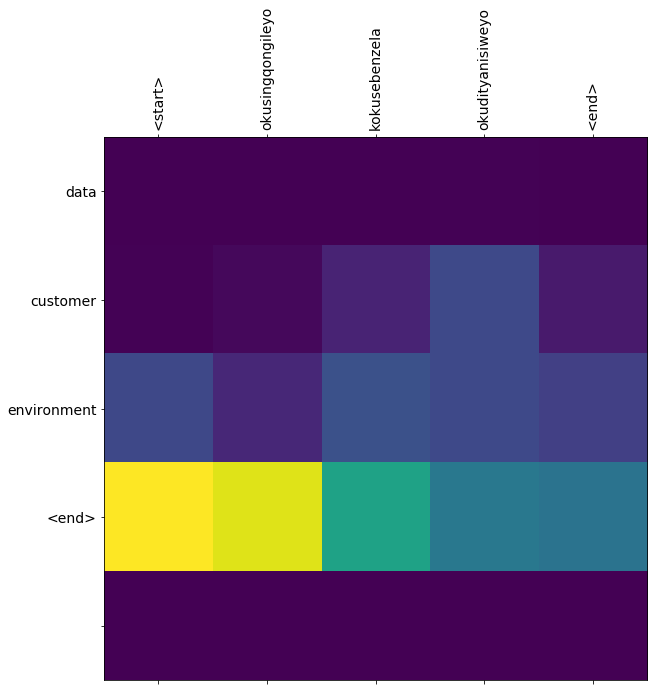

In [36]:
translate(u'Okusingqongileyo kokusebenzela okudityanisiweyo')

Input: <start> okusingqongileyo kokusebenzela okusemgangathweni <end>
Predicted translation: bewss battlefield environment <end> 


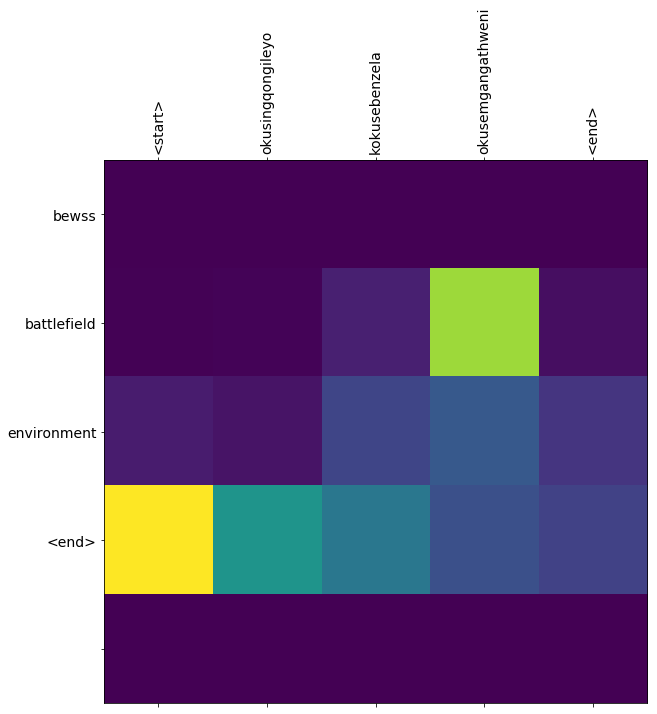

Input: <start> imikhosi yemisebenzi ekhethekileyo <end>
Predicted translation: air and air distribution <end> 


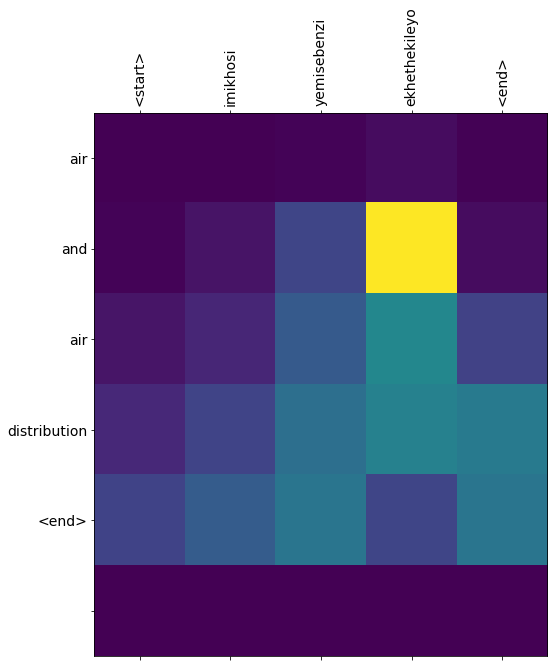

Input: <start> ulwimi oluboniswe ngemfaniso <end>
Predicted translation: object oriented language <end> 


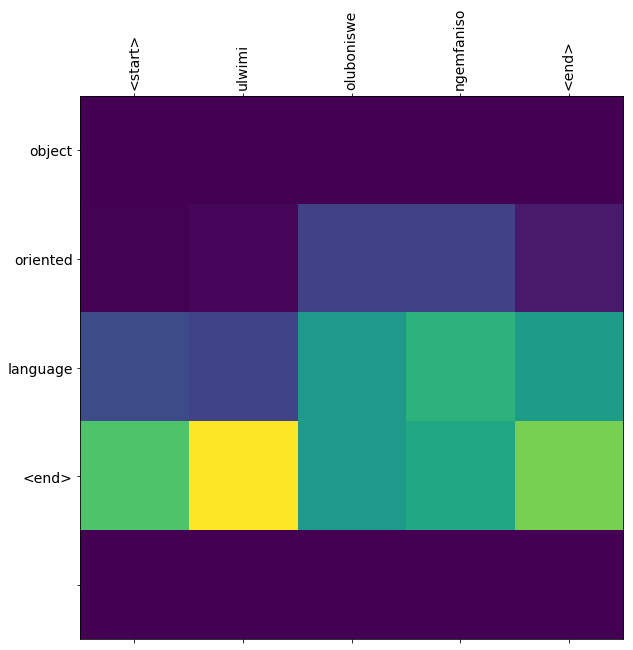

Input: <start> imodeli yelungu lwemfaniso <end>
Predicted translation: simulation model . <end> 


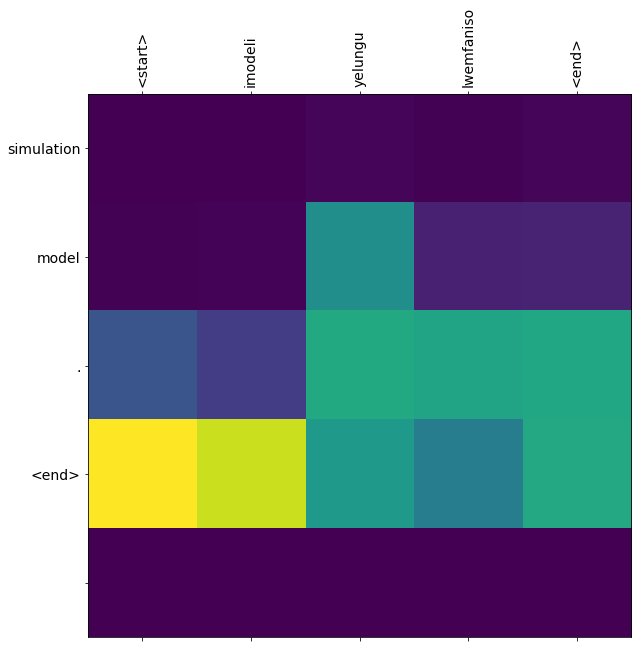

Input: <start> uqinisekiso lobulunga be software <end>
Predicted translation: software engineering environments <end> 


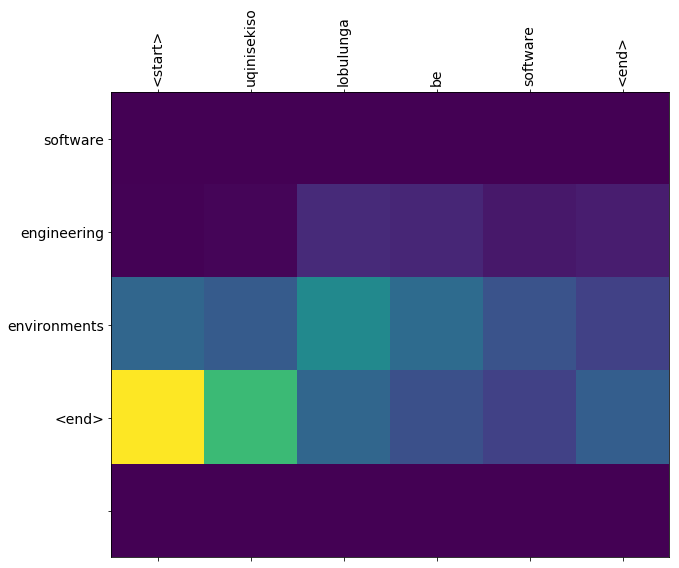

Input: <start> ulwimi lokubuza olulungiselelweyo <end>
Predicted translation: louisiana language <end> 


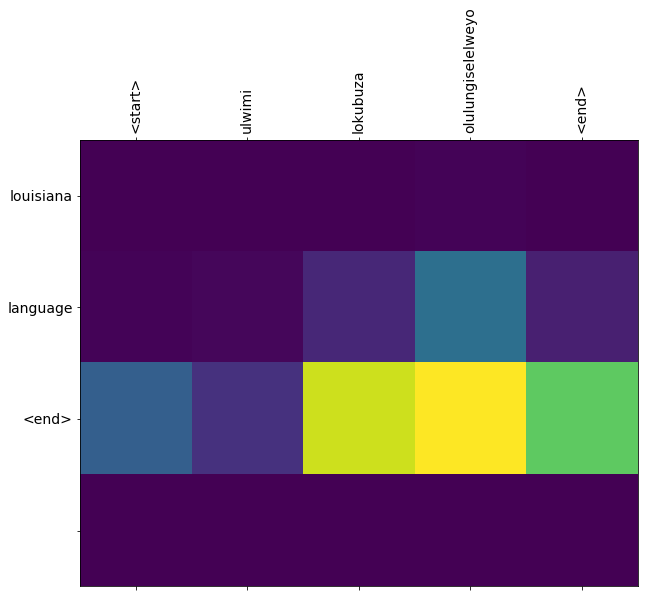

Input: <start> isicwangciso senkxaso yemfaniso <end>
Predicted translation: simulation network service <end> 


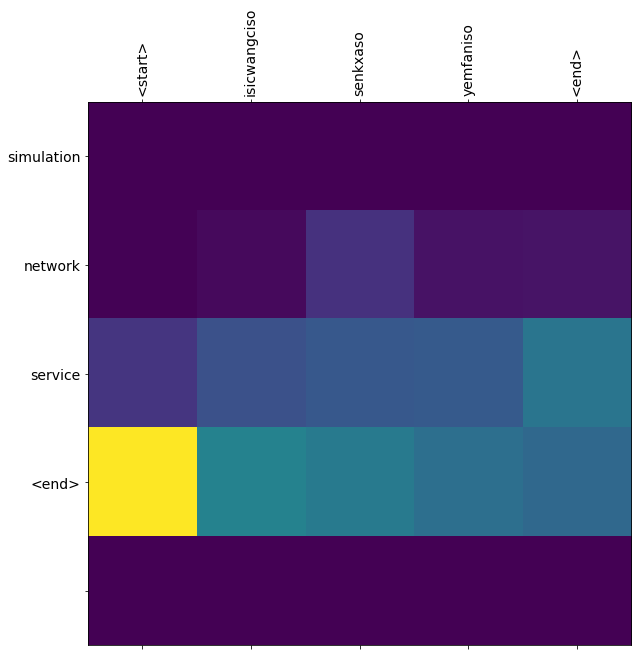

Input: <start> uvavanyo kunye nohlolo <end>
Predicted translation: joint and evaluation <end> 


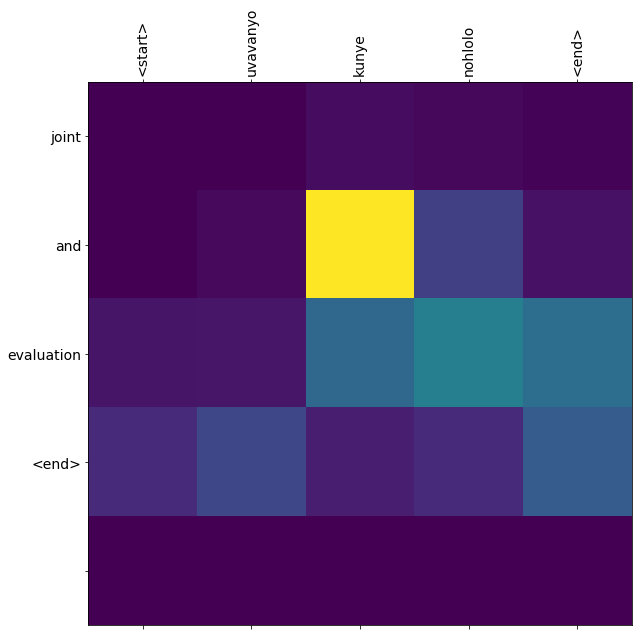

Input: <start> uqeqesho kunye nemfaniso <end>
Predicted translation: data and simulation <end> 


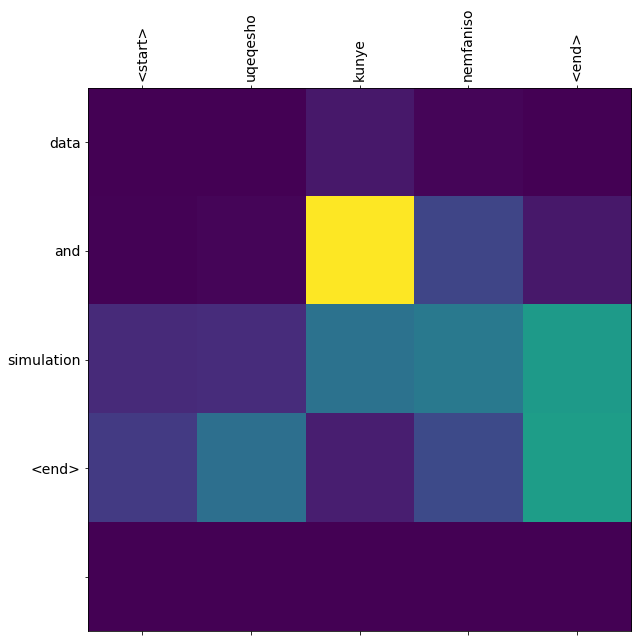

In [37]:
translate(u'Okusingqongileyo kokusebenzela okusemgangathweni')
translate(u'Imikhosi yemisebenzi ekhethekileyo')
translate(u'Ulwimi oluboniswe ngemfaniso')
translate(u'Imodeli yelungu lwemfaniso')
translate(u'Uqinisekiso lobulunga be-Software')
translate(u'Ulwimi lokubuza olulungiselelweyo')
translate(u'Isicwangciso senkxaso yemfaniso')
translate(u'Uvavanyo kunye nohlolo')
translate(u'Uqeqesho kunye nemfaniso')


Input: <start> okusingqongileyo kokusebenzela okusemgangathweni <end>
Predicted translation: bewss battlefield environment <end> 


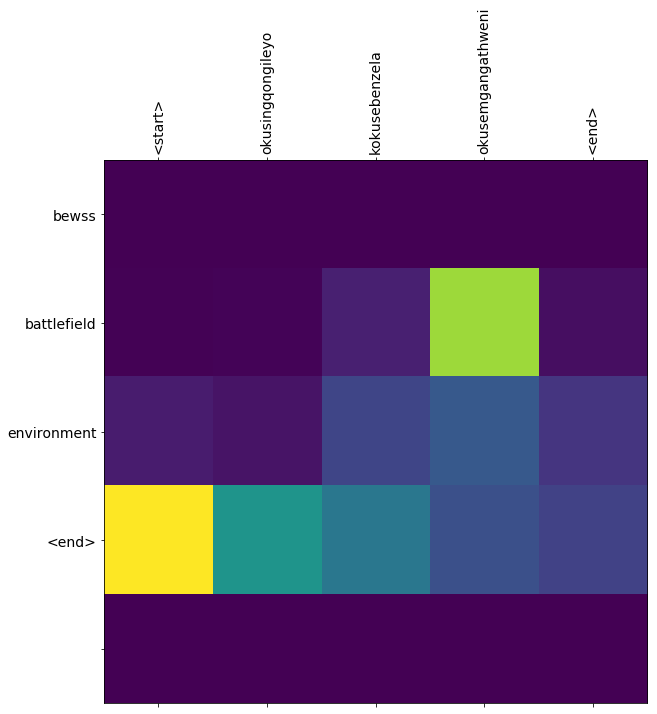

In [38]:
translate(u'Okusingqongileyo kokusebenzela okusemgangathweni')

Input: <start> imikhosi yemisebenzi ekhethekileyo <end>
Predicted translation: air and air distribution <end> 


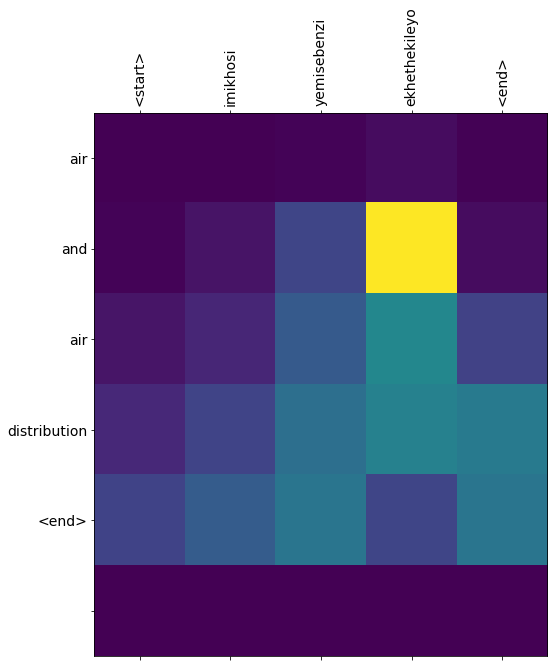

In [39]:
translate(u'Imikhosi yemisebenzi ekhethekileyo')

Input: <start> ulwimi oluboniswe ngemfaniso <end>
Predicted translation: object oriented language <end> 


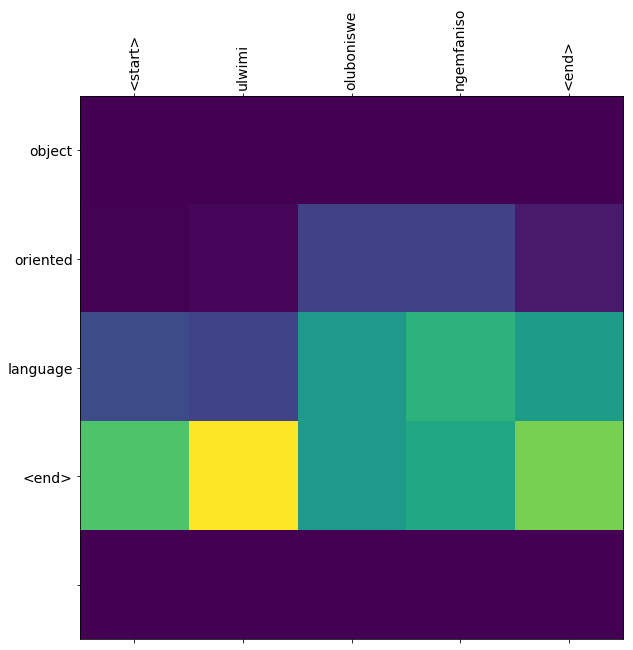

In [40]:
translate(u'Ulwimi oluboniswe ngemfaniso')


Input: <start> imodeli yelungu lwemfaniso <end>
Predicted translation: simulation model . <end> 


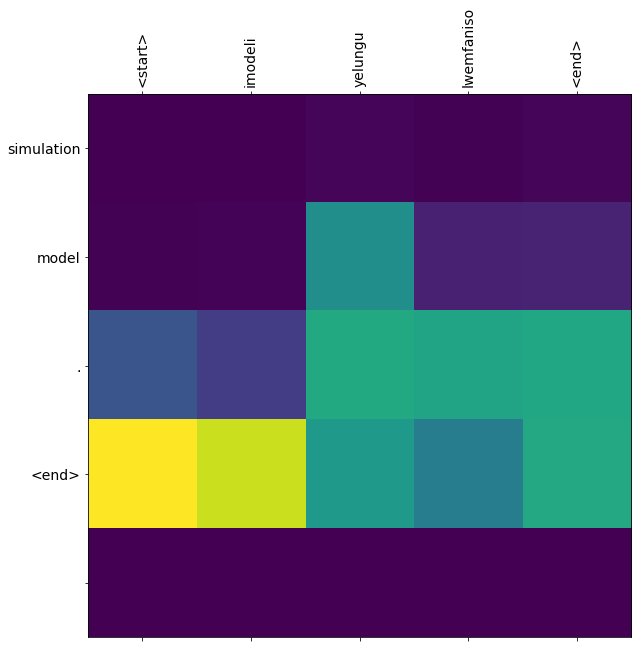

In [41]:
translate(u'Imodeli yelungu lwemfaniso')


Input: <start> uqinisekiso lobulunga be software <end>
Predicted translation: software engineering environments <end> 


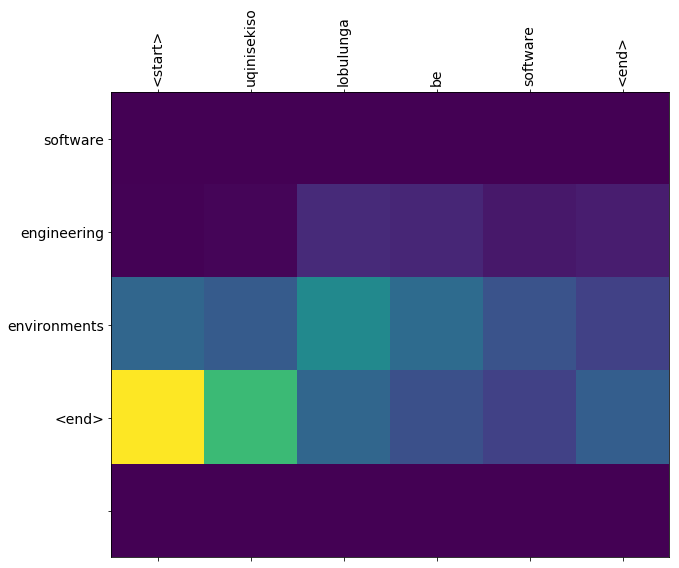

In [42]:
translate(u'Uqinisekiso lobulunga be-Software')


Input: <start> ulwimi lokubuza olulungiselelweyo <end>
Predicted translation: louisiana language <end> 


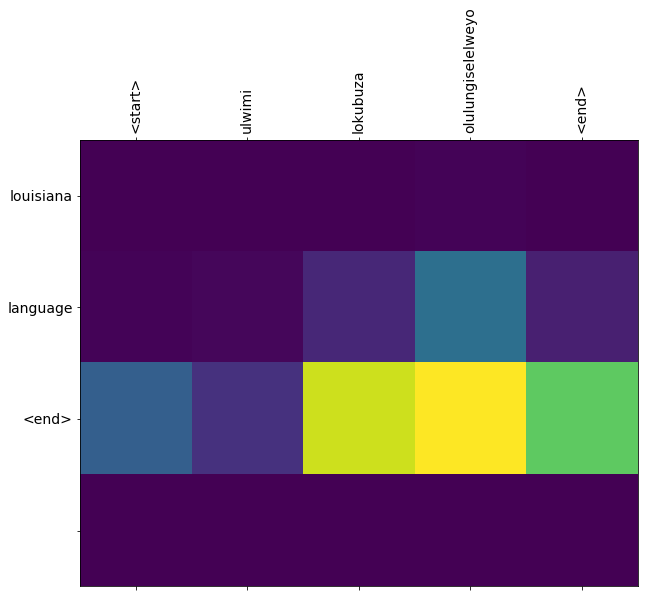

In [43]:
translate(u'Ulwimi lokubuza olulungiselelweyo')


Input: <start> isicwangciso senkxaso yemfaniso <end>
Predicted translation: simulation network service <end> 


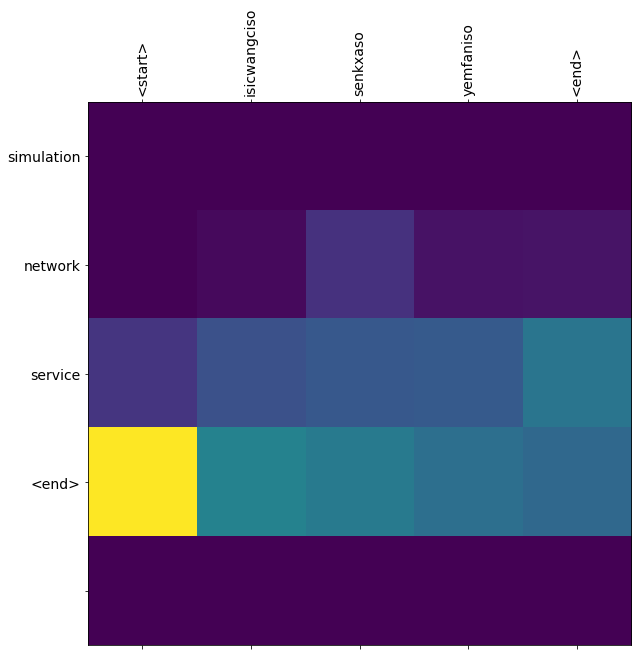

In [44]:
translate(u'Isicwangciso senkxaso yemfaniso')


Input: <start> uvavanyo kunye nohlolo <end>
Predicted translation: joint and evaluation <end> 


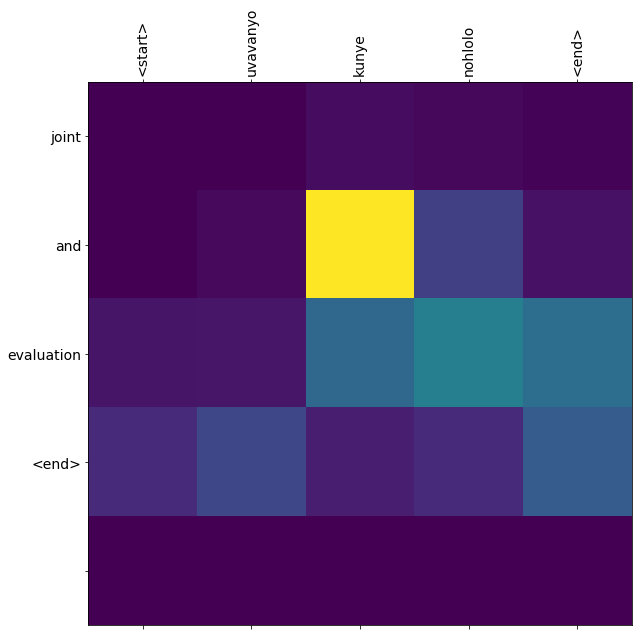

In [45]:
translate(u'Uvavanyo kunye nohlolo')


Input: <start> uqeqesho kunye nemfaniso <end>
Predicted translation: data and simulation <end> 


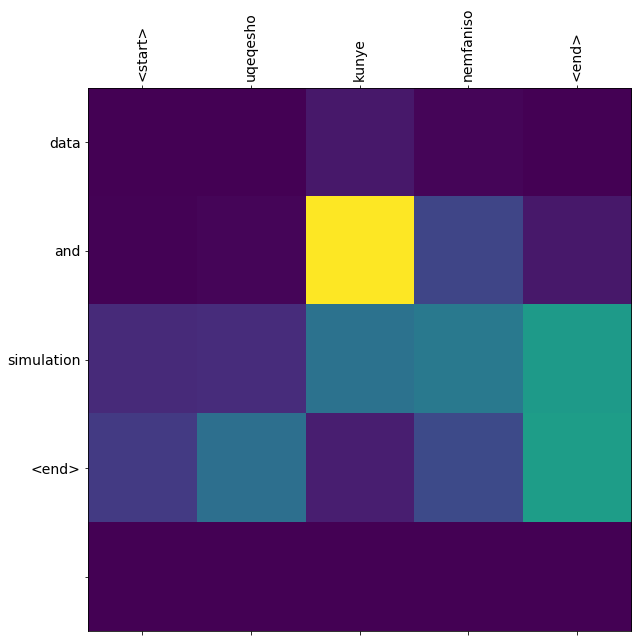

In [46]:
translate(u'Uqeqesho kunye nemfaniso')

In [47]:
""""
translate(u'Okusingqongileyo kokusebenzela okusemgangathweni')
translate(u'Imikhosi yemisebenzi ekhethekileyo')
translate(u'Ulwimi oluboniswe ngemfaniso')
translate(u'Imodeli yelungu lwemfaniso')
translate(u'Uqinisekiso lobulunga be-Software')
translate(u'Ulwimi lokubuza olulungiselelweyo')
translate(u'Isicwangciso senkxaso yemfaniso')
translate(u'Uvavanyo kunye nohlolo')
translate(u'Uqeqesho kunye nemfaniso')

Synthetic Operating Environment
Standard Operating Environment
Special Operations Forces
Simulation Oriented Language
Simulation Object Model
Software Quality Assurance
Structured Query Language
Simulation Support Plan
Test and Evaluation
Training and Simulation
""""

SyntaxError: ignored